In [23]:
#https://www.macroption.com/historical-volatility-calculation/
import json
import requests
import warnings
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.tri as mtri
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from iexfinance.stocks import Stock, get_historical_data
from iexfinance import get_stats_recent
from fredapi import Fred
from pytradier import *
from options_ import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open('config.json') as f:
    data = json.load(f)
fred_key = data['fred']
tradier_key = data['tradier']
plotly_cred = data['plotly']

In [4]:
#FRED 
tradier = Tradier(tradier_key)
plotly.tools.set_credentials_file(username= plotly_cred['username'], api_key= plotly_cred['api-key'])
plotly.tools.set_config_file(world_readable=True,
                             sharing='public')
fred = Fred(api_key=fred_key)

In [25]:
portfolio = ['MSFT', 'BA', 'AAPL', 'V', 'GOOGL', 'SPY']
stocks = Stock(portfolio)
p = stocks.get_price()
options_dates = [1, 3, 6, 9]

In [12]:
d = timedelta(days = 61)
yest = timedelta(days = 1)
start = date.today()-d
end = date.today()-yest
historicals = get_historical_data(portfolio, start, end, output_format='pandas').reset_index()
dates = historicals['date']

In [7]:
#Candlestick Graph
df = historicals[portfolio[0]].join(dates)
trace = go.Ohlc(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])
data = [trace]
py.iplot(data, filename='simple_candlestick')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jaisal1024/0 or inside your plot.ly account where it is named 'simple_candlestick'


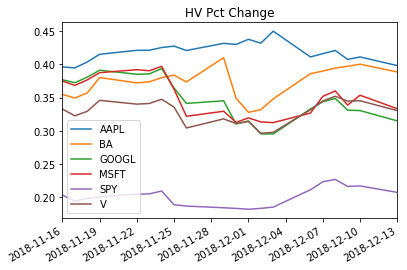

In [14]:
hv_1_df_ = hv_1(historicals, portfolio)
hv_1_df_.plot(title = 'HV Pct Change')

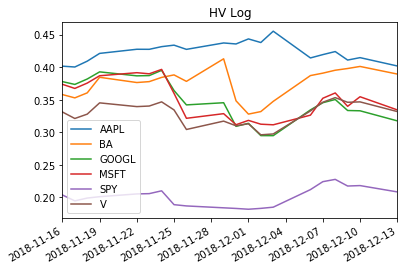

In [16]:
hv_2_df_ = hv_2(historicals, portfolio)
hv_2_df_.plot(title = 'HV Log')

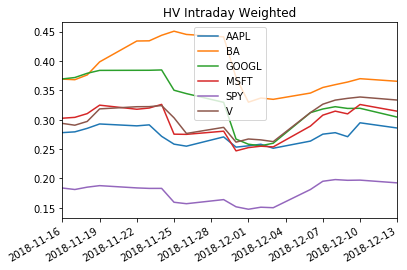

In [17]:
hv_weighted_df_ = hv_weighted(historicals, portfolio, 1)
hv_weighted_df_.plot(title = 'HV Intraday Weighted')

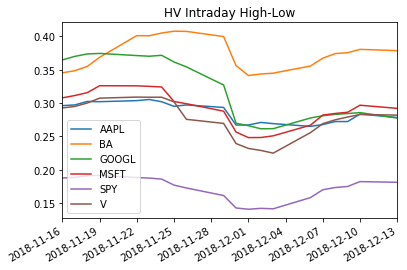

In [18]:
hv_hl_df_ = hv_hl(historicals, portfolio)
hv_hl_df_.plot(title = 'HV Intraday High-Low')

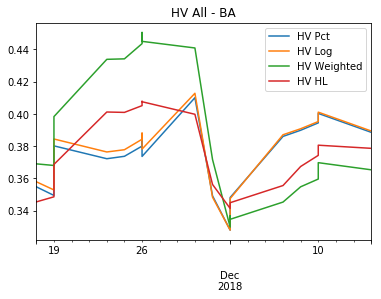

In [19]:
hv_all_ = hv_all('BA', hv_1_df_, hv_2_df_, hv_weighted_df_, hv_hl_df_)
hv_all_.plot(title = 'HV All - BA')

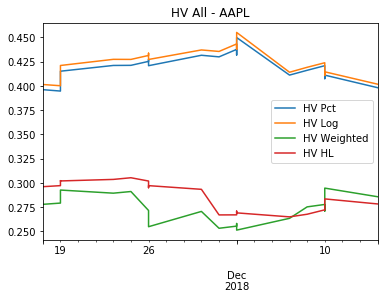

In [20]:
hv_all_ = hv_all('AAPL', hv_1_df_, hv_2_df_, hv_weighted_df_, hv_hl_df_)
hv_all_.plot(title = 'HV All - AAPL')

In [21]:
def graph_option_1(chain, stock):
    chain_ = chain.loc[chain['Stock'] == stock]
    fig = plt.figure()
    ax = Axes3D(fig)
    Axes3D.mouse_init(ax)
    surf = ax.plot_trisurf(chain_["Strike"], chain_["T"], chain_["Call Premium"], cmap=cm.RdBu, linewidth=0.5, antialiased=False)
    ax.set_title('3-D Options Surface for '+ stock)
    # fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


def graph_option_subplot(chain, chain_2, stock, stock_2 = None): 
    if (stock_2 == None): 
        stock_2 = stock
    chain_ = chain.loc[chain['Stock'] == stock]
    chain_2 = chain.loc[chain['Stock'] == stock_2]
    
    x = chain_["Strike"]
    y = chain_["T"]
    tri = mtri.Triangulation(x, y)
    
    fig = plt.figure(figsize=plt.figaspect(0.25))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_trisurf(x,y, chain_["Call Premium"], triangles=tri.triangles, cmap=plt.cm.CMRmap,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)
    
    x1 = chain_2["Strike"]
    y1 = chain_2["T"]
    tri = mtri.Triangulation(x1, y1)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_trisurf(x1, y1, chain_2["Spread"], triangles=tri.triangles, cmap=plt.cm.Spectral,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)

    plt.show()
    
def graph_real_option_subplot(chain, stock): 
    chain_ = chain.loc[((chain['underlying'] == stock) & (chain['option_type'] == 'call'))]
    chain_2 = chain.loc[((chain['underlying'] == stock) & (chain['option_type'] == 'put'))]
    
    x = chain_["strike"]
    y = chain_["T"]
    tri = mtri.Triangulation(x, y)
    
    fig = plt.figure(figsize=plt.figaspect(0.25))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_trisurf(x,y, chain_["Spread"], triangles=tri.triangles, cmap=plt.cm.CMRmap,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)
    
    x1 = chain_2["strike"]
    y1 = chain_2["T"]
    tri = mtri.Triangulation(x1, y1)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_trisurf(x1, y1, chain_2["Spread"], triangles=tri.triangles, cmap=plt.cm.Spectral,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)

    plt.show()

### Each quarter, on the third Friday in March, June, September, and January*

In [27]:
t_exp = {}
for stock in portfolio:    
    t_exp[stock] = t_(date.today(), options_dates)

In [28]:
for stock in portfolio: 
    for i in range(len(t_exp[stock])): 
        while(not tradier.check_expiration(t_exp[stock][i], stock)): 
            print(stock, t_exp[stock][i])
            t_ = input()
            t_ = t_.split(',')
            t_ = date(int(t_[0]), int(t_[1]), int(t_[2]))
            t_exp[stock][i] = t_

BA 2019-03-15
2019,02,15
BA 2020-06-19
2021,01,15
V 2020-06-19
2021,01,15


In [30]:
r = list((fred.get_series('DGS1', sort_order = 'desc', limit = 1).to_dict()).values())[0]/100
q_matrix = extractQ(p, stocks)
strikes = strikes_(p, 5)
default = list((fred.get_series('BAMLH0A0HYM2', sort_order = 'desc', limit = 1).to_dict()).values())[0]/100
stats = stocks.get_key_stats()
beta = {}
for stock in portfolio:
    beta[stock] = stats[stock]['beta']

In [31]:
chains_blackscholes = pd.DataFrame(columns = ["Stock", "Underlying Price", "Call Premium", "Put Premium", "Strike", "Expiry", "T"])
i = 0
sigma_matrix = hv_weighted_df_.iloc[len(hv_weighted_df_.index)-1].to_dict()
for stock in strikes: 
    for t_d in t_exp[stock]:
        for x in strikes[stock]:
            sigma = sigma_matrix[stock]
            q = q_matrix[stock]
            t = ((t_d-date.today()).days)/365 
            s = p[stock]
            d1 = d1_(s, x, t, r, q, sigma)
            d2 = d2_(d1, sigma, t)
            obj = {
                    "Stock": stock,
                    "Underlying Price": s, 
                    "Call Premium": round(call_(s, x, t, r, q, d1, d2), 4),
                    "Put Premium": round(put_(s, x, t, r, q, d1, d2), 4),
                    "Strike": x,
                    "Expiry": t_d, 
                    "T": t
                }
            temp = pd.DataFrame(obj, index = [i])
            chains_blackscholes = pd.concat([chains_blackscholes, temp], ignore_index = True)  
            i+=1       

In [33]:
chains_extension = pd.DataFrame(columns = ["Stock", "Underlying Price", "Call Premium", "Put Premium", "Strike", "Expiry", "T"])
i = 0
sigma_matrix = hv_weighted_df_.iloc[len(hv_weighted_df_.index)-1].to_dict()
for stock in strikes: 
    for t_d in t_exp[stock]:
        for x in strikes[stock]:
            sigma = sigma_matrix[stock]
            q = q_matrix[stock]
            t = ((t_d-date.today()).days)/365 
            s = p[stock]
            d1 = d1_(s, x, t, r, q, sigma)
            d2 = d2_(d1, sigma, t)
            obj = {
                    "Stock": stock,
                    "Underlying Price": s, 
                    "Call Premium": round(call_(s, x, t, r, q, d1, d2) * M_(1, default, beta[stock], t), 4),
                    "Put Premium": round(put_(s, x, t, r, q, d1, d2) * (1/M_(1, default, beta[stock], t)), 4),
                    "Strike": x,
                    "Expiry": t_d, 
                    "T": t
                }
            temp = pd.DataFrame(obj, index = [i])
            chains_extension = pd.concat([chains_extension, temp], ignore_index = True)  
            i+=1  

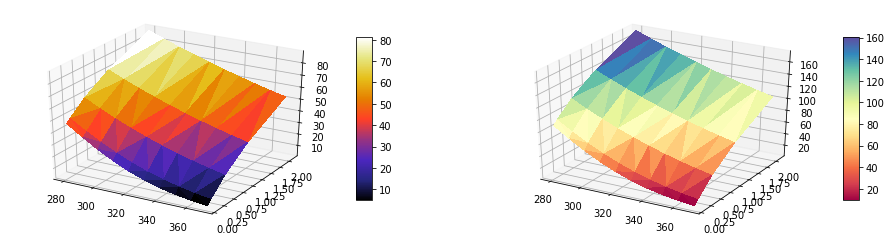

In [252]:
graph_option_subplot(chains_blackscholes, chains_extension, portfolio[1])

In [81]:
strikes = tradier.get_option_strikes(portfolio[0], t_exp[0])

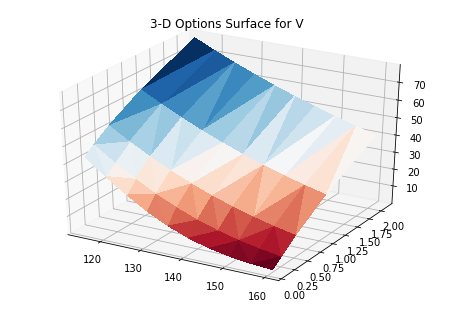

In [254]:
graph_option_1(chains_extension, portfolio[3])

In [258]:
chain_realtime = pd.DataFrame(columns = ['ask','bid', 'strike', 'underlying', 'volume', 'expiration_date', 'option_type'])
for stock in portfolio: 
    for t in t_exp[stock]: 
        temp = tradier.get_option_chain(stock, t, "pandas")
        temp = temp[temp['strike'].isin(strikes[stock])]
        temp = temp[['ask','bid', 'strike', 'underlying', 'volume', 'expiration_date', 'option_type']]
        chain_realtime = pd.concat([chain_realtime,temp])
chain_realtime.reset_index()

,index,ask,bid,strike,underlying,volume,expiration_date,option_type
0,0,1.98,1.92,105.0,MSFT,3563,2019-01-18,put
1,3,0.23,0.21,90.0,MSFT,62,2019-01-18,put
2,4,15.25,14.95,95.0,MSFT,42,2019-01-18,call
3,5,6.75,6.50,105.0,MSFT,613,2019-01-18,call
4,7,0.96,0.92,100.0,MSFT,934,2019-01-18,put
5,10,0.12,0.09,85.0,MSFT,214,2019-01-18,put
6,12,20.10,19.70,90.0,MSFT,20,2019-01-18,call
7,13,10.75,10.45,100.0,MSFT,123,2019-01-18,call
8,17,25.05,24.30,85.0,MSFT,0,2019-01-18,call
9,42,20.95,20.40,130.0,MSFT,0,2019-01-18,put


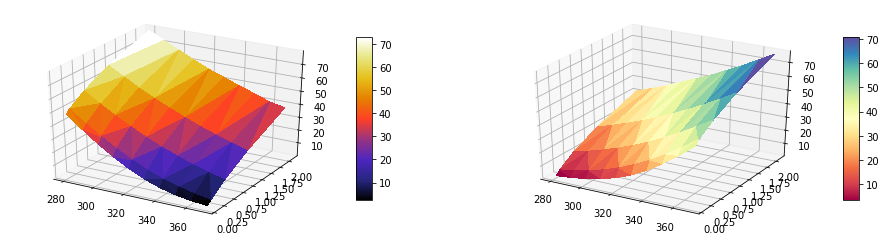

In [287]:
graph_real_option_subplot(chain_realtime, portfolio[1])

In [304]:
temp = chain_realtime[((chain_realtime['underlying'] == stock) & (chain_realtime['option_type'] == 'call'))]
surface = go.Surface(x=temp["strike"], y=temp["T"], z=temp["Spread"])
data = [surface]

layout = go.Layout(
    title='Parametric Plot',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Realtime options call data on MSFT')